In [336]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import modeling
from astropy.modeling import models, fitting
from photutils.isophote import EllipseGeometry
from photutils import EllipticalAperture
from photutils.isophote import Ellipse
from photutils.isophote import build_ellipse_model
from burst_utils import find_burst, boxcar_kernel
import matplotlib
import scipy.signal as ss

In [337]:
#Formatting

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [363]:
def boxcar_kernel(width):
    """Returns the boxcar kernel of given width normalized by
    sqrt(width) for S/N reasons.
    Parameters
    ----------
    width : int
        Width of the boxcar.
    Returns
    -------
    boxcar : array_like
        Boxcar of width `width` normalized by sqrt(width).
    """
    width = int(round(width, 0))
    return np.ones(width, dtype="float32") / np.sqrt(width)


def find_burst(ts, width_factor=4, min_width=1, max_width=2048):
    """Find burst peak and width using boxcar convolution.

    Parameters
    ----------
    ts : array_like
        Time-series.
    width_factor : int, optional
        Windowing factor for on and off-pulse determination.
    min_width : int, optional
        Minimum width to search from, in number of time samples.
        1 by default.
    max_width : int, optional
        Maximum width to search up to, in number of time samples.
        128 by default.

    Returns
    -------
    peak : int
        Index of the peak of the burst in the time-series.
    width : int
        Width of the burst in number of samples.
    snr : float
        S/N of the burst.

    """
    min_width = int(min_width)
    max_width = int(max_width)

    # do not search widths bigger than timeseries
    widths = list(range(min_width,
                        min(max_width + 1, int((len(ts) - 50) // 6))))

    # envelope finding
    snrs = np.empty_like(widths, dtype=float)
    peaks = np.empty_like(widths, dtype=int)

    # borders for on and off-pulse determination
    outer = 3 * width_factor // 2
    inner = width_factor // 2

    for i in range(len(widths)):
        convolved = ss.convolve(ts, boxcar_kernel(widths[i]))
        peaks[i] = np.nanargmax(convolved)
        # peak should not be on the edge of time-series
        if (peaks[i] > 0.999 * ts.shape[0]) or (peaks[i] < 0.001 * ts.shape[0]):
            snrs[i] = np.nan
        else:
            # get RMS for S/N weighting, as in PRESTO's single_pulse_search.py
            baseline = np.concatenate(
                [
                    convolved[0 : max(0, peaks[i] - 3 * widths[i])],
                    convolved[peaks[i] + 3 * widths[i] :],
                ]
            )

            # cutoff of at least 50 samples is a bit arbitrary, but seems
            # reasonable
            if baseline.shape[0] > 50:
                rms = np.std(baseline)
            else:
                rms = np.nan

            snrs[i] = convolved[peaks[i]] / rms

    best_idx = np.nanargmax(snrs)

    return peaks[best_idx]-widths[best_idx]//2, widths[best_idx], snrs[best_idx]

In [364]:
def sub_npy(npy_fil, subfactor, file_duration, bandwidth, center_frequency):
    
    npy = np.load(npy_fil)
    npy_sub = np.flipud(np.nanmean(npy.reshape(-1, subfactor, npy.shape[1]), axis=1))
    timeseries = npy_sub.sum(0)

    return npy, npy_sub, timeseries

In [365]:
#GBT B Specs

subfactor = 64
bandwidth = 400 #MHz
center_frequency = 800 #MHz
file_duration = 83.33 #ms


#For convenience
bw = float(bandwidth) #MHz
cfreq = float(center_frequency) #MHz

In [378]:
npy_fil = 'scintillation/B_686_dm348.8.fits.npy'

npy, npy_sub, timeseries = sub_npy(npy_fil, subfactor, file_duration, bandwidth, center_frequency)
peaks, widths, snrs = find_burst(timeseries)
print(peaks, widths)

3072 283


In [379]:
#Resolutions
tres = file_duration / npy.shape[1]
print('Raw Time Resolution (microsec): ', tres*1e3)
nchan = npy.shape[0]
fres = bw / nchan
print('Raw Frequency Resolution (kHz): ', fres*1e3)

Raw Time Resolution (microsec):  20.34423828125
Raw Frequency Resolution (kHz):  52.083333333333336


In [380]:
#Shape Check
print('GBT_G:', npy.shape)

GBT_G: (7680, 4096)


In [381]:
#Define windowing depending on where burst sits in dynspec
window_left = peaks - 2*widths
window_right = peaks + 2*widths

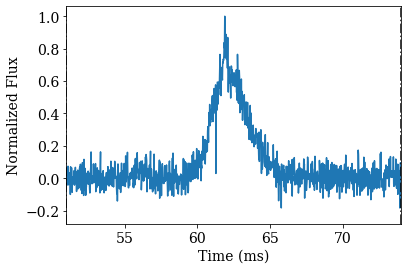

In [382]:
fig = plt.figure()
time = np.linspace(0, len(timeseries), len(timeseries))
timeseries_norm = timeseries/np.max(timeseries)
plt.plot(time*tres, timeseries_norm)
#plt.axvline(peaks, c = 'r', linestyle = 'dotted')
plt.axvline(window_left*tres, c = 'k', linestyle = 'dashdot')
plt.axvline(window_right*tres, c = 'k', linestyle = 'dashdot')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Flux')
plt.xlim(window_left*tres, window_right*tres)
plt.show()

In [383]:
#Crop
time_zoom = np.linspace(0, round(window_right - window_left), round(window_right - window_left))
timeseries_zoom = timeseries_norm[window_left:window_right]

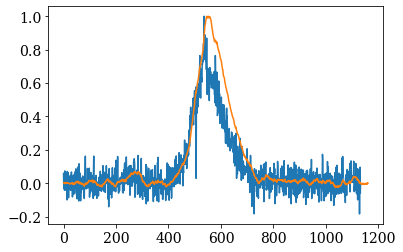

In [384]:
plt.plot(time_zoom, timeseries_zoom)
convolved = ss.convolve(timeseries_zoom, boxcar_kernel(30))
convolved = convolved/np.max(convolved)
plt.plot(convolved/np.max(convolved))

#Find Peaks for Fitting
peaks = ss.find_peaks(convolved)[0]
widths = ss.peak_widths(convolved, peaks)
main_peak = widths[2][np.argmax(widths[0])]

In [385]:
print('Fitter Message: ')
#gauss_exp_init = models.Gaussian1D(0.8, main_peak, 20.)+ models.Gaussian1D(1.2, 220, 40.) + models.Exponential1D(1., -53.)
gauss_exp_init = models.Gaussian1D(0.8, main_peak, 20.) + models.Exponential1D(0.5, -10.)
fitter = modeling.fitting.LevMarLSQFitter()
gauss_exp_fit = fitter(gauss_exp_init, time_zoom, timeseries_zoom)
print(fitter.fit_info['message'])
print(gauss_exp_fit)

Fitter Message: 
Number of calls to function has reached maxfev = 100.
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=0.67848041, mean=552.41905707, stddev=57.63169297)>

    [1]: <Exponential1D(amplitude=0.05307701, tau=-0.09568497)>
Parameters:
       amplitude_0           mean_0      ...        tau_1        
    ------------------ ----------------- ... --------------------
    0.6784804061923024 552.4190570740212 ... -0.09568496661792326


/Users/jakobfaber/.pyenv/versions/3.7.3/lib/python3.7/site-packages/astropy/modeling/functional_models.py:2677: RuntimeWarning: overflow encountered in exp
  return amplitude * np.exp(x / tau)


In [386]:
#Peaks
peaks = ss.find_peaks(convolved)[0]

#Peak Widths
widths = ss.peak_widths(convolved, peaks)
width_indices = np.sort(widths[0])[-2:]

#Peak Prominences
prominences = ss.peak_prominences(convolved, peaks)
prom_indices = np.sort(prominences[0])[-2:]

peak_locations = [np.where(prominences[0] == i)[0][0] for i in prom_indices]

print('Peak 1: ', widths[2][peak_locations])

Peak 1:  [239.61111132 499.79589419]


120
8
16
16
24
24
32
32
40
40
48
48
56
56
64
64
72
72
80
-29.46647949557433
2263
2263
1132
1132
1132
11.0


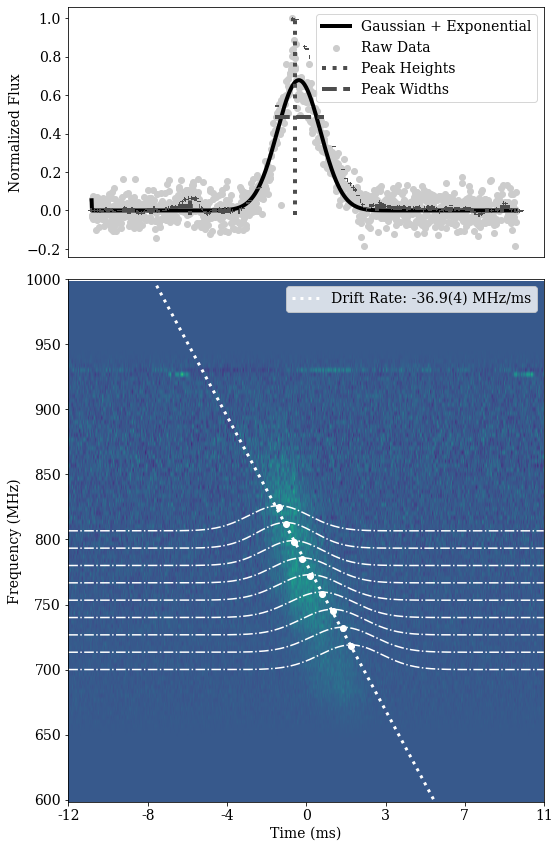

In [389]:
fig = plt.figure(figsize = (8, 12))

grid = fig.add_gridspec(9, 1)

ax1 = fig.add_subplot(grid[0:3, 0])

plt.scatter(time_zoom+10, timeseries_zoom, c = '0.8', label = 'Raw Data')
contour_heights = convolved[peaks] - prominences[0]
plt.vlines(x=peaks, ymin=contour_heights, ymax=convolved[peaks], color = '0.3', zorder = 3, linestyle = 'dotted', linewidth = 4, label = 'Peak Heights')
plt.hlines(*widths[1:], color='0.3', zorder = 4, linestyle = 'dashed', linewidth = 4, label = 'Peak Widths')
plt.plot(time_zoom+10, gauss_exp_fit(time_zoom), linewidth = 4, c = 'black', \
         label = 'Gaussian + Exponential')
         #label = 'Double Gaussian + Exponential')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Normalized Flux')
plt.legend()

ax2 = fig.add_subplot(grid[-6:, 0])

twidth = npy_sub[:, window_left:window_right].shape[1] * tres
time_drift = np.linspace(-twidth/2, twidth/2, npy_sub[:, window_left:window_right].shape[1])
#plt.imshow(np.flipud(npy_sub[:, window_left:window_right]), extent = [-twidth/2, twidth/2, 600, 1000], interpolation = None, aspect = 'auto', cmap= 'viridis')
#plt.imshow(npy_sub, interpolation = None, aspect = 'auto')
#plt.plot(time_drift, dr(time_drift, slope, b), c = 'w', linestyle = 'dotted', linewidth = 3, label = 'Drift Rate: -38(6) MHz/ms')
#plt.plot(time_drift, np.repeat(400, (window_right-window_left)), c = 'w')

print(npy_sub.shape[0])
maxs = []
maxgauss = []
npy_sub_pulse = npy_sub[:, window_left:window_right]
l = [int(i) for i in np.arange(8, npy_sub_pulse.shape[0], 8)[:-4]]
y_scat = []
x_scat = []
for i in range(len(l)-1):
    print(l[i])
    print(l[i]+8)
    sub_time_zoom = npy_sub_pulse[l[i]:l[i]+8, :].sum(0)
    #print(sub_time_zoom)
    npy_sub_corr = ss.correlate(sub_time_zoom, timeseries_zoom)
    npy_sub_corr_norm = npy_sub_corr / np.max(npy_sub_corr)
    #plt.plot(npy_sub_corr_norm[npy_sub_corr_norm.shape[0]//4: -npy_sub_corr_norm.shape[0]//4]+i, c = 'k')
    sub_time_max = np.argmax(npy_sub_corr_norm)
    maxs.append(sub_time_max)
    sub_time = np.linspace(0, len(npy_sub_corr_norm), len(npy_sub_corr_norm))
    fitter = modeling.fitting.LevMarLSQFitter()
    model = modeling.models.Gaussian1D(amplitude=1., mean=sub_time_max, stddev=0.5)
    fitted_model = fitter(model, sub_time, npy_sub_corr_norm)
    maxgauss.append(fitted_model.mean[0])
    plt.plot((fitted_model(sub_time[sub_time.shape[0]//4+15:-sub_time.shape[0]//4+15]))*6+i*4+30, c = 'w', linestyle = 'dashdot')
    #plt.plot((subccnorm), c = 'b', linestyle = 'dashdot')
    x_scat.append(fitted_model.mean[0]-sub_time.shape[0]//4)
    y_scat.append(i*4+35.5)
    plt.scatter(fitted_model.mean[0]-sub_time.shape[0]//4-15, i*4+35.5, c = 'w', marker = 'o', lw =1.)
plt.imshow(npy_sub_c, aspect = 'auto')#extent = [-twidth/2, twidth/2, 1000, 600], aspect = 'auto')
#plt.plot(np.unique(npy_sub_c.shape[1]), np.poly1d(np.polyfit([i - 15 for i in x_scat], y_scat, 1))(np.unique(npy_sub_c.shape[1])), c = 'w', linestyle = 'dotted', label = "Drift Rate")
m, b = np.poly1d(np.polyfit([i - 15 for i in x_scat], y_scat, 1))
def dr(xdr, slope, b):
            return slope*xdr + b
plt.plot(np.linspace(0, npy_sub_c.shape[1],npy_sub_c.shape[1])[210:870] , dr(np.linspace(0, npy_sub_c.shape[1],npy_sub_c.shape[1])[210:870], m, b), c = 'w', linestyle = 'dotted', linewidth = 3, label = 'Drift Rate: -36.9(4) MHz/ms')
plt.legend()
print(m*((400)/npy_sub.shape[0])/tres)
print(len(sub_time))
print(len(npy_sub_corr_norm))
print(npy_sub_pulse.shape[1])
print(len(timeseries_zoom))
print(len(sub_time_zoom))
print(twidth//2)
plt.xticks([round(i) for i in np.linspace(0, npy_sub_pulse.shape[1], 7)], [round(i) for i in np.linspace(-twidth//2., twidth//2., 7)])
plt.yticks([round(i) for i in np.linspace(0, npy_sub_pulse.shape[0], 9)], [round(i) for i in np.linspace(600, 1000, 9)])
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (MHz)')
plt.gca().invert_yaxis()
plt.tight_layout()
#plt.legend()

fig.savefig('GBT_B_Drift_CrossCorr.png', dpi = 600)

#fig.savefig('MultiComponent_GMRTA_AAS_Plot.png', dpi=600)
plt.show()

In [6]:
tres = 83.33 / subrawnc.shape[1]
fres = 400 / subrawnc.shape[0]

print('Time Res(ms) ', tres)
print('Freq. Res (MHz) ', fres)

Time Res(ms)  0.02034423828125
Freq. Res (MHz)  0.8333333333333334


[0, 28, 57, 85, 114, 142, 171, 200, 228, 257, 285, 314]
[360.4752239330705, 110.0260818897715, 515.2862718897826, 372.1136219482039, 368.73153392938667, 392.6684269526853, 410.5501014555309, 425.150309128858, 442.396076464018, 460.3169866045397, 476.94402165722624]
Drift Rate (MHz/ms):  -19.929271594612175


NameError: name 'subsm' is not defined

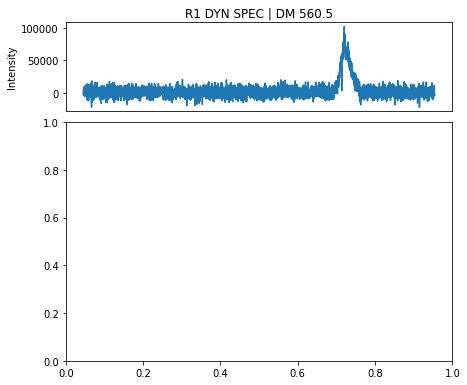

In [8]:

l = [int(i) for i in np.linspace(0, 400, 15)][:-3]
print(l)
r = [i + 50 for i in l]

maxs = []
maxgaus = []
for i in range(len(l)-1):
    subts = sub[l[i]:r[i], :].sum(0) * 20
    subcc = ss.correlate(subts, sub.sum(0))
    subccnorm = subcc / np.max(subcc)
    x = np.linspace(0, len(subccnorm), len(subccnorm))
    xmaxs = np.where(subccnorm == np.max(subccnorm))[0]
    maxs.append(xmaxs[0])
    fitter = modeling.fitting.LevMarLSQFitter()
    model = modeling.models.Gaussian1D(amplitude=1., mean=xmaxs[0], stddev=0.5)
    fitted_model = fitter(model, x, subccnorm)
    maxgaus.append(fitted_model.mean[0])
print(maxgaus)
#print(len(maxs), len(l[:-1]))
#plt.scatter(maxs, np.flip((l[:-1])))

x2 = np.linspace(450, 760, len(l))

fit = fitting.LinearLSQFitter()
line_init = models.Linear1D()
fitted_line = fit(line_init, maxgaus, l[:-1])
driftrate = fitted_line.slope[0]*(-fres/tres)
print('Drift Rate (MHz/ms): ', driftrate)

fig = plt.figure(figsize = (12, 5))
gs = fig.add_gridspec(7, 2)
ax1 = fig.add_subplot(gs[0:2, 0])
plt.plot(subrawnc.sum(0))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Intensity')
plt.tight_layout()
plt.title('R1 DYN SPEC | DM 560.5')


ax2 = fig.add_subplot(gs[-5:, 0])
plt.imshow(subsm, aspect = 'auto')
plt.plot(x2+20, fitted_line(x2)+710, linestyle = 'dotted', c = 'w', \
         label = 'Drift Rate: ' + str('%s' % float('%.5g' % driftrate)) + ' MHz/ms')
#plt.scatter(maxs, l[:-1], c = 'w', marker = 'o', lw =.005)
#plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)

for i in range(len(l)-1):
    subts = sub[l[i]:r[i], :].sum(0) * 10
    subcc = ss.correlate(subts, sub.sum(0))
    subccnorm = subcc / np.max(subcc)
    xmax = np.where(subccnorm == np.max(subccnorm))[0]
    maxs.append(xmax[0])
    #plt.plot((-subccnorm*50)+l[i]+50, c = 'w', linestyle = 'dashdot')
#plt.legend()
plt.ylabel('Frequency Channels')
plt.xlabel('Time Bins')
plt.legend()
plt.tight_layout()


ax3 = fig.add_subplot(gs[0:2, 1])
plt.plot(acfsm.sum(0)/np.max(acfsm.sum(0)))#acfsm.sum(1))
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)#, labelbottom=False)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('R1 2D ACF | DM 560.5')

ax4 = fig.add_subplot(gs[-5:, 1])
plt.imshow(acfsm, interpolation=None, aspect = 'auto')
#plt.imshow(acf2d, aspect = 'auto')
#aper.plot(color='blue')
x3 = np.linspace(950, 2060, len(l)*2)
#plt.plot(x3+300, fitted_line(x3), linestyle = 'dotted', c = 'w', \
#         label = 'Drift Rate: ' + str('%s' % float('%.5g' % driftrate)) + ' MHz/ms')
for i in range(len(l)-1):
    subts = sub[l[i]:r[i], :].sum(0) * 10
    subcc = ss.correlate(subts, sub.sum(0))
    subccnorm = subcc / np.max(subcc)
    xmax = np.where(subccnorm == np.max(subccnorm))[0]
    maxs.append(xmax[0])
    plt.plot((-subccnorm*60)+l[i]+250, c = 'w', linestyle = 'dashdot')
#plt.legend()
#plt.ylabel('Frequency Channels')
#plt.xlabel('Time Bins')
#plt.tight_layout()
#xacf = np.linspace(0, acfsm.shape[0], acfsm.shape[0])
#x2 = np.linspace(acfsm.shape[1]//2 - 17, acfsm.shape[1]//2 + 18.2)
#plt.plot(x2, fitted_line(x2), c = 'w')
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)#, labelbottom=False)
plt.xlabel('Time Lag')
#plt.legend()
plt.show()
fig.savefig('R1_Drift_Crosscorr_dynacf.png')

[0, 21, 42, 64, 85, 107, 128, 150, 171, 192, 214]


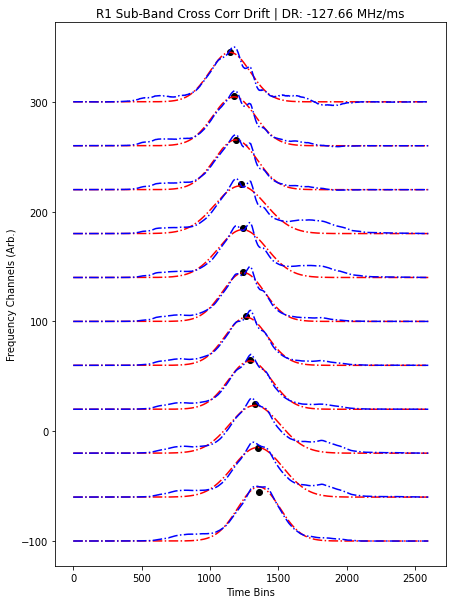

In [149]:
fig = plt.figure(figsize = (7, 10))
maxs = []
maxgaus = []
for i in range(len(l)-1):
    subts = sub[l[i]:r[i], :].sum(0)
    subcc = ss.correlate(subts, sub.sum(0))
    subccnorm = subcc / np.max(subcc)
    xmax = np.where(subccnorm == np.max(subccnorm))[0][0]
    #maxs.append(xmax[0])
    x = np.linspace(0, len(subccnorm), len(subccnorm))
    fitter = modeling.fitting.LevMarLSQFitter()
    model = modeling.models.Gaussian1D(amplitude=1., mean=xmax, stddev=0.5)
    fitted_model = fitter(model, x, subccnorm)
    maxgaus.append(fitted_model.mean[0])
    plt.plot((fitted_model(x))*50-i*40+300, c = 'r', linestyle = 'dashdot')
    plt.plot((subccnorm*50)-i*40+300, c = 'b', linestyle = 'dashdot')
    plt.scatter(fitted_model.mean[0], -i*40+345, c = 'k', marker = 'o', lw =1.)
print(l[:-1])
plt.ylabel('Frequency Channels (Arb.)')
plt.xlabel('Time Bins')
plt.title('R1 Sub-Band Cross Corr Drift | ' + 'DR: ' + str('%s' % float('%.5g' % driftrate)) + ' MHz/ms')
plt.show()
fig.savefig('R1_Drift_Crosscorr.png')